In [65]:
#This Renders a high quality animation of the river data moving.


#Let's import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime

import os

from midiutil import MIDIFile

%matplotlib inline

Total Precipitation Entries: 222332
Clear Lake Discharge Entries: 175590
Lookout Ck Entries: 275297
  DBCODE  ENTITY SITECODE PRECIP_METHOD  HEIGHT QC_LEVEL PROBE_CODE  \
0  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   
1  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   
2  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   

        date  PRECIP_TOT_DAY PRECIP_TOT_FLAG EVENT_CODE  
0 1957-10-01             4.1               A     METHOD  
1 1957-10-02            27.4               A        NaN  
2 1957-10-03            22.9               A        NaN   

  agency_cd   site_no       date  discharge 01_00060_00003_cd
0      USGS  14158500 1912-10-01      256.0                 A
1      USGS  14158500 1912-10-02      254.0                 A
2      USGS  14158500 1912-10-03      252.0                 A 

        date STCODE  FORMAT SITECODE  WATERYEAR  MEAN_Q_cfs  MAX_Q  MIN_Q  \
0 1949-10-01  HF004       2   GSLOOK       1950       

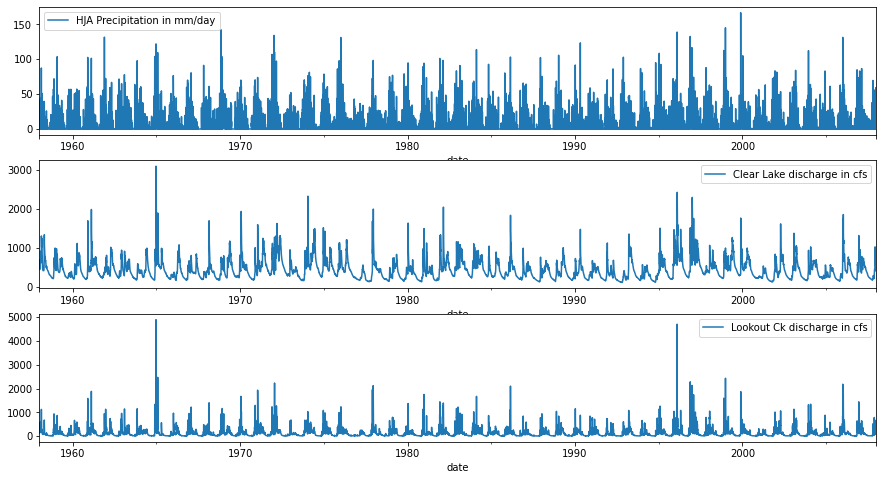

In [66]:
path = os.path.abspath(os.getcwd())

df_precip = pd.read_excel("{}/Cascade_Data/Precip_HJASite101.xlsx".format(path), parse_dates=[7])
print('Total Precipitation Entries:', df_precip.size)

df_clearlake = pd.read_excel("{}/Cascade_Data/ClearLake.xls".format(path), header=27)
print('Clear Lake Discharge Entries:', df_clearlake.size)

df_lookout = pd.read_excel("{}/Cascade_Data/LOOKOUT_GSLOOK.xlsx".format(path), parse_dates= {"date" : ["year","month","day"]})
print('Lookout Ck Entries:', df_lookout.size)

print(df_precip.head(3), '\n')
print(df_clearlake.head(3), '\n')
print(df_lookout.head(3))

#we need to sort the data by data
dfp=df_precip.sort_values(by=['date'])
dfc=df_clearlake.sort_values(by=['date'])
dfl=df_lookout.sort_values(by=['date'])

# rename some of the columns that we will be working with
dfp = dfp.rename(columns={'PRECIP_TOT_DAY': 'HJA Precipitation in mm/day'})
dfc = dfc.rename(columns={'discharge': 'Clear Lake discharge in cfs'})
dfl = dfl.rename(columns={'MEAN_Q_cfs': 'Lookout Ck discharge in cfs'})

#check that the sampling rate is same
dtp = (dfp.date[1] - dfp.date[0])
dtl = (dfl.date[1] - dfl.date[0])
dtc = (dfc.date[1] - dfc.date[0])

#find common time frame between the datasets
start = '1958-01-01'
end = '2008-01-01'

conditionP = (dfp['date'] > start) & (dfp['date'] <= end)
dp=dfp.loc[conditionP]
conditionL = (dfl['date'] > start) & (dfl['date'] <= end)
dl=dfl.loc[conditionL]
conditionC = (dfc['date'] > start) & (dfc['date'] <= end)
dc=dfc.loc[conditionC]

print(sum(conditionP==True),sum(conditionC==True),sum(conditionL==True))
print(dp.shape[0],dc.shape[0],dl.shape[0])

#plot it up
fig,ax = plt.subplots(3,figsize=(15,8));
ax[0]=dp.plot(x="date", y="HJA Precipitation in mm/day",ax=ax[0]);
ax[1]=dc.plot(x="date", y="Clear Lake discharge in cfs",ax=ax[1]);
ax[2]=dl.plot(x="date", y="Lookout Ck discharge in cfs",ax=ax[2]);
fig.savefig('Cascades_Q_Lookout_ClearLake.png')

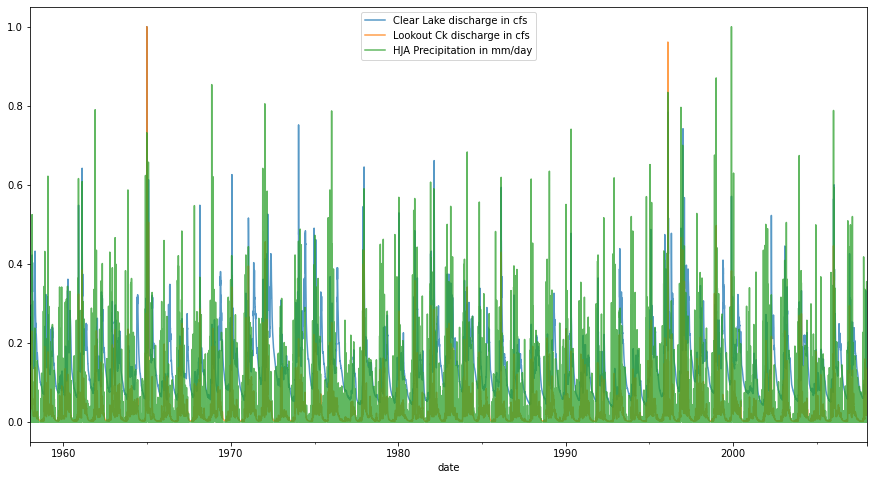

In [67]:
# Norm the data, processed different so the lines look nicer

# compile the list of dataframes we want to merge
data_frames = [dp, dc, dl]
#merge them using the common date column
df_mergedALL = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames)

#then reduce clutter by making a final dataframe that just has the quantities of interest
df_pcl = df_mergedALL[['date','HJA Precipitation in mm/day', 'Clear Lake discharge in cfs', 'Lookout Ck discharge in cfs']].copy()
df_pcl.head(3)

#lets make this a little more readable
#df_norm=(df_pcl-df_pcl.min())/(df_pcl.max()-df_pcl.min())
df_norm=df_pcl.copy()
df_norm["Clear Lake discharge in cfs"] = df_norm["Clear Lake discharge in cfs"]  / df_norm["Clear Lake discharge in cfs"].abs().max()
df_norm["Lookout Ck discharge in cfs"] = df_norm["Lookout Ck discharge in cfs"]  / df_norm["Lookout Ck discharge in cfs"].abs().max() #+ .35
df_norm["HJA Precipitation in mm/day"] = df_norm["HJA Precipitation in mm/day"]  / df_norm["HJA Precipitation in mm/day"].abs().max() #+ .65


fig,ax = plt.subplots(figsize=(15,8));
ax=df_norm.plot(x="date", y=["Clear Lake discharge in cfs", "Lookout Ck discharge in cfs", "HJA Precipitation in mm/day"],ax=ax, alpha=0.75)

In [68]:
# Functions
def set_midi_notes_for_mode(start_note, octaves, mode):
    #Returns a list of Diatonic Notes in the Mode
    #Returns a 2nd list of Accidental Notes not in the Mode
    
    modes = {
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2]
    }
    
    diatonics = []
    accidentals = []
    
    for octave in range(octaves):
        note = start_note + (12*octave) #first octave = 0, 2nd=1, etc
        
        for step in modes[mode]:
            diatonics.append(note)
            note = note + step
    last_note = start_note + (octaves*12) #sets last note
    diatonics.append(last_note) #there must be a better way to do this
    
    for i in range(octaves*12): #in range of all semitones
        note = start_note + i
        
        if note not in diatonics:
            accidentals.append(note)
            
    return diatonics, accidentals

def loc_on(start_date, end_date, df):
    #Locks on to a set time of dates
    
    condition = (df['date'] > start_date) & (df['date'] <= end_date)
    return_df=df.loc[condition] 
    
    return return_df

def get_years(total_start_date, total_end_date):
    #returns a list of strings to use as date entries for loc_on
    tstart = datetime.strptime(total_start_date, '%Y-%m-%d')
    tend = datetime.strptime(total_end_date, '%Y-%m-%d')
    
    all_years = []
    for y in range(tstart.year, tend.year+1):
        all_years.append(y)
    
    return all_years

def alt_basic_diatonic_midifile_withmiditime(midifile, bpm, note_duration, midi_data, miditime_start):
    #Writes as usual but takes miditime as a parameter. Returns the time and the midifile
    
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = miditime_start
    
    mymidi = midifile
    
    for note in range(len(midi_data)):
        mymidi.addNote(track, channel, int(midi_data[note]), miditime, note_duration, velocity)
        miditime += note_duration
    
    return mymidi, miditime

def diatonic_midifile_destroy_duples(midifile, bpm, note_duration, midi_data, miditime_start):
    #Writes as usual but takes miditime as a parameter. Also if the note before is the same, just adds length to the note.
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = miditime_start
    
    mymidi = midifile
    moving_duration = note_duration
    write_note = midi_data[0]
    
    for note in range(1, len(midi_data)):
        
        if midi_data[note] == midi_data[note-1]:
            moving_duration += note_duration
            
        elif midi_data[note] != midi_data[note-1]:
            mymidi.addNote(track, channel, int(write_note), miditime, moving_duration, velocity)
            miditime += moving_duration
            moving_duration = note_duration
            write_note = midi_data[note]
        
    mymidi.addNote(track, channel, int(write_note), miditime, moving_duration, velocity)
    miditime += moving_duration

    return mymidi, miditime

def del_repeat_points(nparray):
    for point in range(1, len(nparray)):
        
        if nparray[point] == nparray[point - 1]: #If the point is the same as the one befor         
            nparray[point] = np.nan # Make the current point nan.
        
        elif np.isnan(nparray[point - 1]) == True: # if the point before is nan
                backpoint = point-1
                
                while np.isnan(nparray[backpoint]) == True: # while the point before is nan
                    backpoint -= 1 #move back in the list
            
                    if nparray[backpoint] == nparray[point]: #if the backpoint equals the current then
                        nparray[point] = np.nan
    return nparray

In [69]:
#Using functions to get stuff, THIS IS WHERE YOU CAN CHANGE THINGS

#Getting data for the music
total_daterange_start = '1982-07-01'
total_daterange_end = '1983-06-30'

years = get_years(total_daterange_start, total_daterange_end)
print('All the Years Going By:', years)

start_note = 43 #G2 #Change this for a different starting notw
octaves = 3
mode = 'ionian'
diatonics, accidentals = set_midi_notes_for_mode(start_note, octaves, mode)
print('New Diatonics:', diatonics)

#Getting the full range for midi mapping.
data_ranges = [df_norm['Clear Lake discharge in cfs'].min(), 
               df_norm['Clear Lake discharge in cfs'].max(),
               df_norm['Lookout Ck discharge in cfs'].min(), 
               df_norm['Lookout Ck discharge in cfs'].max()]
datamin = min(data_ranges)
datamax = max(data_ranges)

All the Years Going By: [1982, 1983]
New Diatonics: [43, 45, 47, 48, 50, 52, 54, 55, 57, 59, 60, 62, 64, 66, 67, 69, 71, 72, 74, 76, 78, 79]


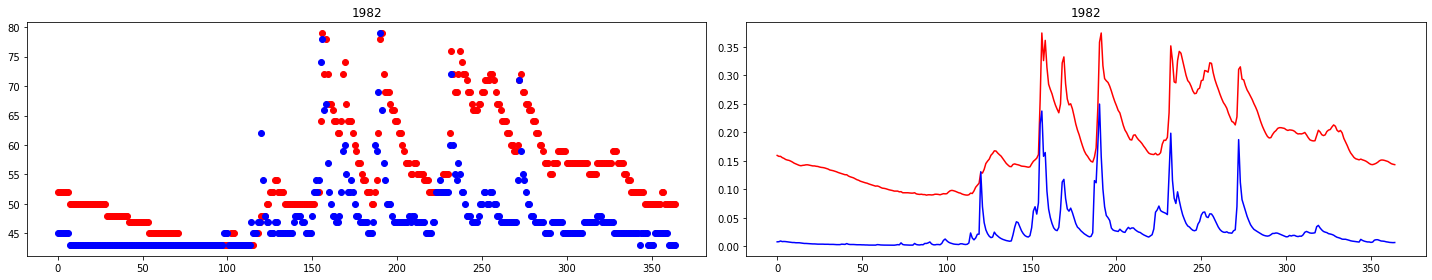

In [70]:
target_n = 365 #Change this number, in samples per year

midi_dict_allyears = {} #Making a dictionary with each year and array
temp_data_agg = {} #Just for plotting purposes
fig, ax = plt.subplots(len(years)-1, 2, figsize=(20, 4)) #Change Figsize to fit

for year in range(len(years)-1):
    start_date = '{}-06-30'.format(years[year])
    end_date = '{}-06-30'.format(years[year+1])
    
    data_4range = loc_on(start_date, end_date, df_norm)
    cl_data = data_4range['Clear Lake discharge in cfs'].values
    lk_data = data_4range['Lookout Ck discharge in cfs'].values
    
    #Getting Sample
    step = int(len(cl_data)/target_n)
    slices = np.linspace(0, 365, target_n)

    #Set Outputs
    data = np.zeros((2, target_n))
    for i in range(len(slices)-1):
        data[0][i]=(cl_data[int(slices[i])])
        data[1][i]=(lk_data[int(slices[i])])
    data[0][-1]=cl_data[-1]
    data[1][-1]=lk_data[-1]
    #nout = np.interp(data, (datamin, datamax), (0, len(diatonics)-1)) #Use this if you want year relative maps
    #nout = np.interp(data, (np.min(data), np.max(data)), (0, len(diatonics)-1)) #Use this if you dont want relative maps
    
    #Use this if you want to interpolate independently
    nout = []
    nout.append( np.interp(data[0], (np.min(data[0]), np.max(data[0])), (0, len(diatonics)-1)) )
    nout.append( np.interp(data[1], (np.min(data[1]), np.max(data[1])), (0, len(diatonics)-1)) )
    
    out = np.zeros((len(nout), len(nout[0]))) #Set official out array

    for i in range(len(nout)):
        for j in range(len(nout[0])):
            s = int(np.round(nout[i][j]))
            out[i,j] = diatonics[s]
            
    midi_dict_allyears[years[year]] = out #THe final Out
    temp_data_agg[years[year]] = [cl_data, lk_data] #Temporary
    
    ax[0].set_title(years[year])
    ax[0].plot(out[0], 'ro')
    ax[0].plot(out[1], 'bo')
    
    ax[1].set_title(years[year])
    ax[1].plot(cl_data, 'r')
    ax[1].plot(lk_data, 'b')
    
plt.tight_layout()

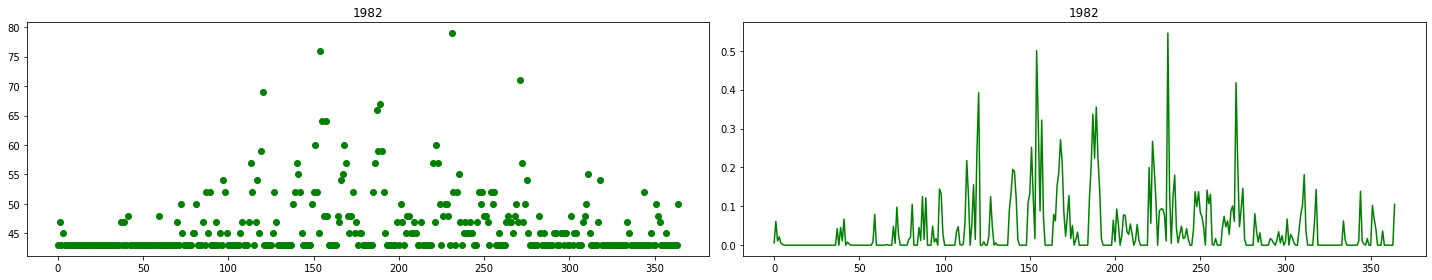

In [71]:
# Now to do the Rain
midi_dict_rainyears = {} #Making a dictionary with each year and array
temp_data_rainagg = {} #Just for plotting purposes

fig, ax =plt.subplots(len(years)-1, 2, figsize=(20, 4)) #Change this to fit graphs
for year in range(len(years)-1):
    start_date = '{}-06-30'.format(years[year])
    end_date = '{}-06-30'.format(years[year+1])
    
    data_4range = loc_on(start_date, end_date, df_norm)
    rain_data = data_4range['HJA Precipitation in mm/day'].values
    
    #Getting Sample
    step = int(len(rain_data)/target_n)
    slices = np.linspace(0, 365, target_n)

    #Set Outputs
    data = np.zeros(target_n)
    
    for i in range(len(slices)-1):
        data[i]=(rain_data[int(slices[i])])
    data[-1]=rain_data[-1]
    #nout = np.interp(data, (datamin, datamax), (0, len(diatonics)-1)) #Use this if you want year relative maps
    
    nout = np.interp(data, (np.min(data), np.max(data)), (0, len(diatonics)-1)) #Use this if you dont want relative maps
    
    out = np.zeros(len(nout)) #Set official out array

    for j in range(len(nout)):
        s = int(np.round(nout[j]))
        out[j] = diatonics[s]
            
    midi_dict_rainyears[years[year]] = out #THe final Out
    temp_data_rainagg[years[year]] = rain_data #Temporary
    
    ax[0].set_title(years[year])
    ax[0].plot(out, 'go')
    
    ax[1].set_title(years[year])
    ax[1].plot(rain_data, 'g')
    
plt.tight_layout()

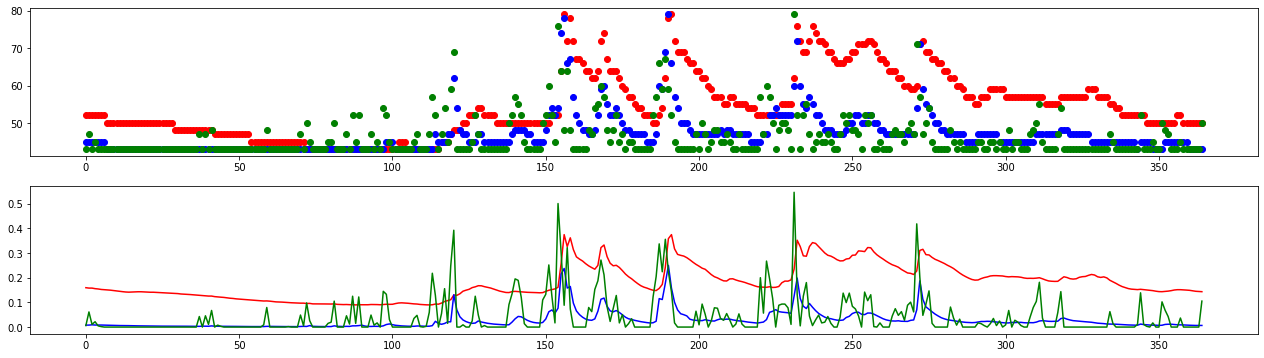

In [72]:
clfull_out = []
lkfull_out = []
rainfull_out = []
cl_data_total = []
lk_data_total = []
rain_data_total = []

for year in midi_dict_allyears.keys():
    clfull_out.extend(midi_dict_allyears[year][0])
    lkfull_out.extend(midi_dict_allyears[year][1])
    rainfull_out.extend(midi_dict_rainyears[year])
    
    
    cl_data_total.extend(temp_data_agg[year][0])
    lk_data_total.extend(temp_data_agg[year][1])
    rain_data_total.extend(temp_data_rainagg[year])
    
num = 10
midirange = target_n * num
yearrange = 365 * num
fig, ax = plt.subplots(2, figsize=(22,6))
ax[0].plot(clfull_out[0:midirange], 'ro')
ax[0].plot(lkfull_out[0:midirange], 'bo')
ax[0].plot(rainfull_out[0:midirange], 'go')

ax[1].plot(cl_data_total[0:yearrange], 'r')
ax[1].plot(lk_data_total[0:yearrange], 'b')
ax[1].plot(rain_data_total[0:yearrange], 'g')

In [73]:
##### DONT RUN THIS UNTIL YOU KNOW HOW MANY FILES YOU WANT

bpm = 100
num_years = 1 #Change this for bigger or smaller ranges within the years you selected Above.

note_duration = 1920 #Half Notes
#note_duration = 960 #quarter Notes
#note_duration = 480 #eighth Notes
#note_duration = 240 #eighth Notes
#note_duration = 120 #16th Notes

phrase_len = note_duration * target_n #Think of this as a Spacer you can use to shift things around.

miditime = 0
cl_midi = MIDIFile(1, eventtime_is_ticks=True) #Making CL file
#cl_midi.addTempo(0, miditime, bpm)

lk_midi = MIDIFile(1, eventtime_is_ticks=True) #Making LK file
#lk_midi.addTempo(0, miditime, bpm)

rain_midi = MIDIFile(1, eventtime_is_ticks=True) #Making Rain file
#rain_midi.addTempo(0, miditime, bpm)

for year in range(num_years):
    cl_midi, miditime = diatonic_midifile_destroy_duples(cl_midi, bpm, int(note_duration), midi_dict_allyears[years[year]][0], miditime)
    lk_midi, miditime = diatonic_midifile_destroy_duples(lk_midi, bpm, int(note_duration), midi_dict_allyears[years[year]][1], miditime)

miditime = 0
for year in range(num_years):
    rain_midi, miditime = diatonic_midifile_destroy_duples(rain_midi, bpm, int(note_duration), midi_dict_rainyears[years[year]], miditime)
    miditime += phrase_len
    
#with open("MidiFiles/{}_1982-83.mid".format('cl'), "wb") as output_file:
    #cl_midi.writeFile(output_file)
    
#with open("MidiFiles/{}_1982-83.mid".format('lk'), "wb") as output_file:
    #lk_midi.writeFile(output_file)
    
#with open("MidiFiles/{}_1982-83.mid".format('rain'), "wb") as output_file:
    #rain_midi.writeFile(output_file)

In [74]:
#Redoing some lists for semantic reasons.

cl_midi_data = clfull_out
lk_midi_data = lkfull_out
rain_midi_data = rainfull_out
cl = cl_data_total 
lk = lk_data_total 
rain = rain_data_total

Text(0, 0.5, 'Discharge in mm')

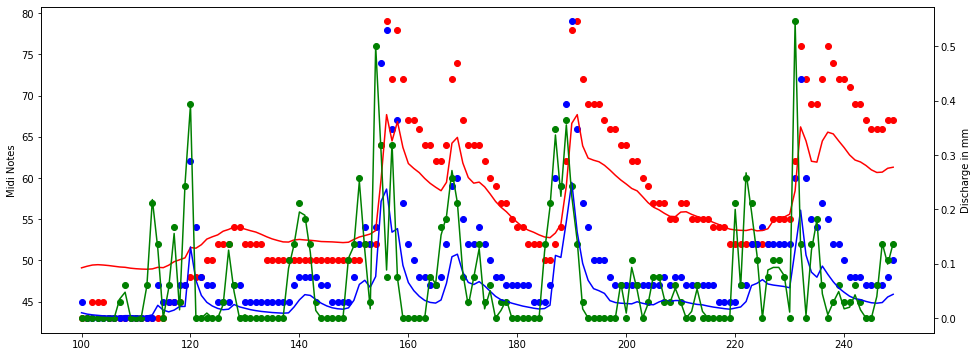

In [75]:
#figuring out differentials within the plot axis.

fig, ax = plt.subplots(figsize=(16,6))
x = np.arange(100,250)

#interp_timetravel = cl_midi_data[134:225].copy()

ax.plot(x, cl_midi_data[100:250], 'ro')
ax.plot(x, lk_midi_data[100:250], 'bo')
ax.plot(x, rain_midi_data[100:250], 'go')
ax.set_ylabel('Midi Notes')

ax2=ax.twinx()
ax2.plot(x, cl[100:250], 'r')
ax2.plot(x, lk[100:250], 'b')
ax2.plot(x, rain[100:250], 'g')
ax2.set_ylabel('Discharge in mm')

Text(0, 0.5, 'Discharge in mm')

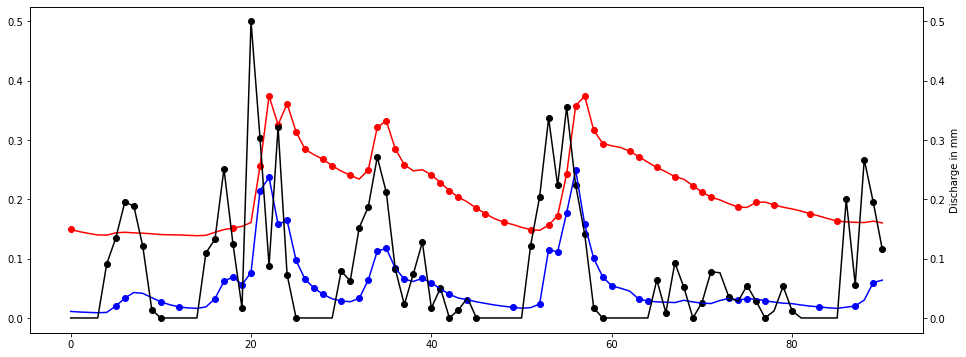

In [76]:
#Another Copy for Safe Keeping
cl_notes = clfull_out.copy()
lk_notes = lkfull_out.copy()
rain_notes = rainfull_out.copy()

#Deleating Repeats
cl_midi_arr = del_repeat_points(cl_notes)
lk_midi_arr = del_repeat_points(lk_notes)
rain_midi_arr = del_repeat_points(rain_notes)

cl_masked = np.ma.masked_where(np.isnan(cl_midi_arr), cl)
lk_masked = np.ma.masked_where(np.isnan(lk_midi_arr), lk)
rain_masked = np.ma.masked_where(np.isnan(rain_midi_arr), rain)

fig, ax = plt.subplots(figsize=(16,6))
#92 days long, Friday November 12th 1982 to Friday February 11th 1983
ax.plot(cl_masked[134:225], 'ro')
ax.plot(lk_masked[134:225], 'bo')
ax.plot(rain_masked[134:225], 'ko')

ax2=ax.twinx()
ax2.plot(cl[134:225], 'r')
ax2.plot(lk[134:225], 'b')
ax2.plot(rain[134:225], 'k')
ax2.set_ylabel('Discharge in mm')

In [77]:
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.interpolate import interp1d

111
111
6660 6660
6660 6660
6660 6660


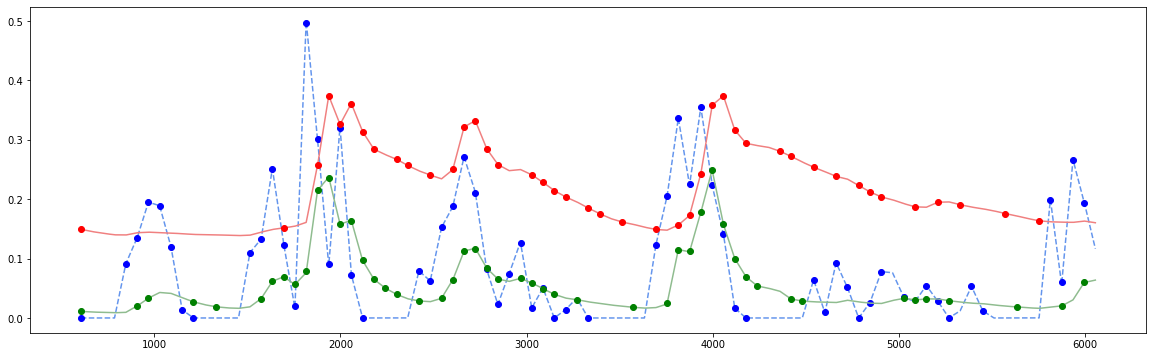

In [80]:
#Randomly Deleted Everything, so I have to recode this final portion from my memory
#Let's start with the interpolation of the ClDouts

#Making Copies of lists
cl_dout = cl[134:225].copy()
lk_dout = lk[134:225].copy()
rain_dout = rain[134:225].copy()

cl_mout = clfull_out[134:225].copy()
lk_mout = lkfull_out[134:225].copy()
rain_mout = rainfull_out[134:225].copy()


#BUFFERING
for i in range(10): #10 day buffer
    cl_dout = np.insert(cl_dout, 0, np.nan)
    cl_mout = np.insert(cl_mout, 0, np.nan)
    
    lk_dout = np.insert(lk_dout, 0, np.nan)
    lk_mout = np.insert(lk_mout, 0, np.nan)
     
    rain_dout = np.insert(rain_dout, 0, np.nan)
    rain_mout = np.insert(rain_mout, 0, np.nan)
#After Buffers
for i in range(10):
    cl_dout = np.append(cl_dout, np.nan)
    cl_mout = np.append(cl_mout, np.nan)
    
    lk_dout = np.append(lk_dout, np.nan)
    lk_mout = np.append(lk_mout, np.nan)
    
    rain_dout = np.append(rain_dout, np.nan)
    rain_mout = np.append(rain_mout, np.nan)

    
#Setting X lengths
xfit = np.linspace(0, 6660, 111)
xnew = np.linspace(0, 6660, 6660) #91*60

#First the Douts
cl_dint = interp1d(xfit, cl_dout, kind='linear')
new_cl_dout = cl_dint(xnew)

lk_dint = interp1d(xfit, lk_dout, kind='linear')
new_lk_dout = lk_dint(xnew)

rain_dint = interp1d(xfit, rain_dout, kind='linear')
new_rain_dout = rain_dint(xnew)


#Now for the Mouts - I hope I remember
#It's about making a list of indexes to the interpolation to zero
cltemp = interp1d(xfit, cl_mout, kind='zero')
cltemp = cltemp(xnew)
cltemp = del_repeat_points(cltemp)
new_cl_mout = np.ma.masked_where(np.isnan(cltemp), new_cl_dout)

lktemp = interp1d(xfit, lk_mout, kind='zero')
lktemp = lktemp(xnew)
lktemp = del_repeat_points(lktemp)
new_lk_mout = np.ma.masked_where(np.isnan(lktemp), new_lk_dout)

raintemp = interp1d(xfit, rain_mout, kind='zero')
raintemp = raintemp(xnew)
raintemp = del_repeat_points(raintemp)
new_rain_mout = np.ma.masked_where(np.isnan(raintemp), new_rain_dout)

print(len(new_cl_dout), len(new_cl_mout))
print(len(new_lk_dout), len(new_lk_mout))
print(len(new_rain_dout), len(new_rain_mout))

#PLOTTING
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(xnew, new_rain_dout, color='cornflowerblue', linestyle='--')
ax.plot(xnew, new_rain_mout, color='blue', marker='o')

ax.plot(xnew, new_cl_dout, color='lightcoral')
ax.plot(xnew, new_cl_mout, 'ro')

ax.plot(xnew, new_lk_dout, color='darkseagreen')
ax.plot(xnew, new_lk_mout, 'go')

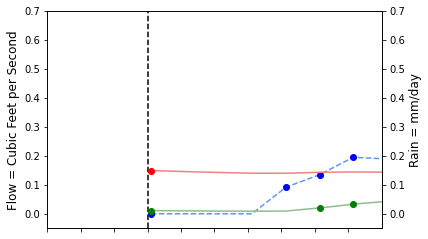

In [146]:
#Getting the plot right before the animation goes down

#Need to set the axes the right way next.

maxwindow = 10*60 
x = np.linspace(0, 6660, 6660)

fig, ax = plt.subplots()

#Setting Axes

ax.set(ylim=(-0.05,0.7))
ax.xaxis.set_ticks(np.arange(0, maxwindow, 60.0))
ax.xaxis.set_ticklabels([])
ax.set_ylabel('Flow = Cubic Feet per Second', size = 12)
ax.axvline(x=3*60, color='black', ls='--')
ax.set_xlim(0,maxwindow)      # THIS limits the window to a certain basis.

ax2=ax.twinx()
ax2.set_ylabel('Rain = mm/day', size = 12)
ax2.set(ylim=(-0.05,0.7))

#Plotting
ax.plot(x[0:10*60], new_rain_dout[7*60:17*60], color='cornflowerblue', linestyle='--')
ax.plot(x[0:10*60], new_rain_mout[7*60:17*60], color='blue', marker='o')

ax.plot(x[0:10*60], new_cl_dout[7*60:17*60], color='lightcoral')
ax.plot(x[0:10*60], new_cl_mout[7*60:17*60], 'ro')

ax.plot(x[0:10*60], new_lk_dout[7*60:17*60], color='darkseagreen')
ax.plot(x[0:10*60], new_lk_mout[7*60:17*60], 'go')

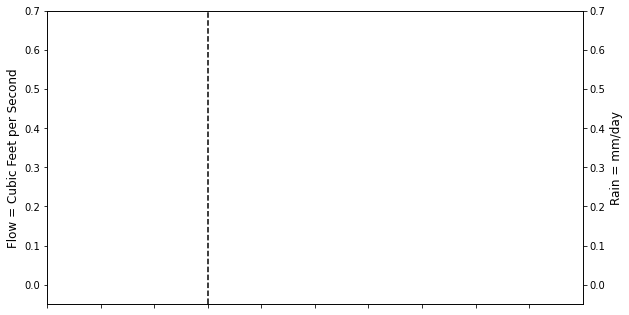

In [151]:
#Time to Animate this big boy

#Init the Fig and Frame List

maxwindow = 10*60 #10 days, sets length of window and plot. 600 points
frame_list = []
fs = (9.6, 5.4) #in Inches

fig, ax = plt.subplots(figsize=fs)

#Setting Axes
ax.set(ylim=(-0.05,0.7))
ax.xaxis.set_ticks(np.arange(0, maxwindow, 60.0))
ax.xaxis.set_ticklabels([])
ax.set_ylabel('Flow = Cubic Feet per Second', size = 12)
ax.axvline(x=3*60, color='black', ls='--')
ax.set_xlim(0,maxwindow)      # THIS limits the window to a certain basis.

ax2=ax.twinx()
ax2.set_ylabel('Rain = mm/day', size = 12)
ax2.set(ylim=(-0.05,0.7))

#Init X
x = np.linspace(0, 6660, 6660)

#The Trigger
for i in range(0, 101*60): #Plot up to the start of the ending buffer
    d1, = ax.plot(x[0:maxwindow], new_rain_dout[i:i+maxwindow], color='cornflowerblue', linestyle='--') #Plot Lines
    d2, = ax.plot(x[0:maxwindow], new_cl_dout[i:i+maxwindow], color='lightcoral')
    d3, = ax.plot(x[0:maxwindow], new_lk_dout[i:i+maxwindow], color='darkseagreen')
    
    p1, = ax.plot(x[0:maxwindow], new_rain_mout[i:i+maxwindow], color='blue', marker='o') #Plot Blits
    p2, = ax.plot(x[0:maxwindow], new_cl_mout[i:i+maxwindow], 'ro')
    p3, = ax.plot(x[0:maxwindow], new_lk_mout[i:i+maxwindow], 'go')
    
    frame_list.append([d1,p1,d2,p2,d3,p3,])

dpi = 200

#UNCOMMENT WHEN READY TO WRITE VIDEO, Took me 2hours 11 min to Render
#anim = animation.ArtistAnimation(fig, frame_list, blit=True)
#writervideo = animation.FFMpegFileWriter(fps=30) 
#anim.save('VideoFiles/RiverMusic.mp4', writer=writervideo, dpi=dpi)